<a href="https://colab.research.google.com/github/laribar/SmartAITraderBot/blob/main/Bot_Funcional_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta
!pip install yfinance
!pip install xgboost
!pip install python-binance


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=916ce8adb1861de089132b949adb59fcd475384a851383a44ccfa83c3b6a417e
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.0 MB/s eta 0:00:00


In [50]:
# ====================================================
# 1. IMPORTAÇÕES
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import requests
import time  # Para usar time.sleep()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ====================================================
# BLOCO 1 - CONFIGURAÇÃO DE PASTAS E IMPORTS EXTRA
# ====================================================
import os
import joblib
from tensorflow.keras.models import load_model

# Criar pasta onde os modelos serão salvos
os.makedirs("/content/models", exist_ok=True)
# ====================================================
# BLOCO 2 - SALVAR E CARREGAR MODELOS TREINADOS
# ====================================================
def get_model_path(asset, interval, model_type="xgb"):
    asset_clean = asset.replace("-", "")
    ext = "joblib" if model_type == "xgb" else "keras"  # Troca h5 → keras
    return f"/content/models/{model_type}_model_{asset_clean}_{interval}.{ext}"


# --- XGBoost ---
def save_xgb_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    joblib.dump(model, path)
    print(f"💾 Modelo XGBoost salvo em: {path}")

def load_xgb_model(asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    if os.path.exists(path):
        print(f"📂 Modelo XGBoost carregado de: {path}")
        return joblib.load(path)
    return None

# --- LSTM ---
def save_lstm_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="lstm")

    # Garante que a extensão seja .keras
    if not path.endswith(".keras"):
        path = path.replace(".h5", ".keras").replace(".joblib", ".keras")

    model.save(path)
    print(f"💾 Modelo LSTM salvo em: {path}")




def load_lstm_model(asset, interval, data=None, window_size=20):
    path = get_model_path(asset, interval, model_type="lstm")
    if os.path.exists(path):
        print(f"📂 Modelo LSTM encontrado em: {path}")
        try:
            model = load_model(path, compile=False)
            model.compile(optimizer="adam", loss="mse")

            print(f"✅ Modelo LSTM carregado com sucesso para {asset} ({interval})")
        except Exception as e:
            print(f"❌ Falha ao carregar modelo LSTM: {e}")
            return None

        model.window_size = window_size

        if data is not None:
            try:
                _, _, scaler = prepare_lstm_data(data, window_size=window_size)
                model.scaler = scaler
            except Exception as e:
                print(f"⚠️ Erro ao aplicar scaler ao LSTM carregado: {e}")
                model.scaler = None
        else:
            print("⚠️ Atenção: LSTM carregado sem dados para gerar o scaler!")
            model.scaler = None

        return model
    else:
        print(f"🚫 Modelo LSTM NÃO encontrado em: {path}")
        return None





# ====================================================
# 2. CONFIGURAÇÕES
# ====================================================
ASSETS = ["BTC-USD"] #, "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "AVAX-USD", "AAVE-USD", "DOT-USD", "NEAR-USD", "ADA-USD"


TIMEFRAMES = [
    {"interval": "15m", "period": "30d", "atr": 0.02},
    {"interval": "1h", "period": "90d", "atr": 0.03},
    {"interval": "1d", "period": "1000d", "atr": 0.05}
]

TELEGRAM_TOKEN = "8044593190:AAFtUWYHd3uqd-AtQi3uqg42F9G6uV95v8k"
TELEGRAM_CHAT_ID = "-4744645054"

# ====================================================
# 3. COLETA DE DADOS
# ====================================================
def get_stock_data(asset, interval="15m", period="60d"):
    data = yf.download(asset, period=period, interval=interval, progress=False, auto_adjust=False)

    # Corrige multi-index
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Corrige nomes padrão e remove colunas duplicadas
    data.columns = [col.split()[-1] if " " in col else col for col in data.columns]
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.rename(columns=lambda x: x.strip().capitalize())

    # Renomeia para padrão consistente
    col_map = {
        "Open": "Open",
        "High": "High",
        "Low": "Low",
        "Close": "Close",
        "Adj Close": "Adj Close",
        "Volume": "Volume"
    }
    data = data.rename(columns={k: v for k, v in col_map.items() if k in data.columns})

    # Garante colunas essenciais
    expected_cols = ["Open", "High", "Low", "Close", "Volume"]
    for col in expected_cols:
        if col not in data.columns:
            raise ValueError(f"⚠️ Coluna ausente: {col}")

    return data.reset_index(drop=True)



# ====================================================
# 4. INDICADORES TÉCNICOS
# ====================================================
def calculate_indicators(data):
    data = data.copy().reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = data[col].astype(float)

    # Indicadores Clássicos
    data["RSI"] = ta.momentum.RSIIndicator(close=data["Close"], window=14).rsi()
    data["SMA_50"] = ta.trend.SMAIndicator(close=data["Close"], window=50).sma_indicator()
    data["SMA_200"] = ta.trend.SMAIndicator(close=data["Close"], window=200).sma_indicator()

    macd = ta.trend.MACD(close=data["Close"])
    data["MACD"] = macd.macd()
    data["MACD_Signal"] = macd.macd_signal()

    bb = ta.volatility.BollingerBands(close=data["Close"], window=20)
    data["Bollinger_Upper"] = bb.bollinger_hband()
    data["Bollinger_Lower"] = bb.bollinger_lband()

    adx = ta.trend.ADXIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["ADX"] = adx.adx()

    stoch = ta.momentum.StochasticOscillator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["Stoch_K"] = stoch.stoch()
    data["Stoch_D"] = stoch.stoch_signal()

    # Indicadores adicionais
    data["ATR"] = ta.volatility.AverageTrueRange(high=data["High"], low=data["Low"], close=data["Close"]).average_true_range()
    data["ROC"] = ta.momentum.ROCIndicator(close=data["Close"], window=12).roc()
    data["OBV"] = ta.volume.OnBalanceVolumeIndicator(close=data["Close"], volume=data["Volume"]).on_balance_volume()
    data["CCI"] = ta.trend.CCIIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=20).cci()

    ichimoku = ta.trend.IchimokuIndicator(high=data["High"], low=data["Low"], window1=9, window2=26)
    data["Tenkan_Sen"] = ichimoku.ichimoku_conversion_line()
    data["Kijun_Sen"] = ichimoku.ichimoku_base_line()

    # VWAP e Candles
    data["TP"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (data["TP"] * data["Volume"]).cumsum() / (data["Volume"].replace(0, np.nan).cumsum())
    data.drop("TP", axis=1, inplace=True)

    data["Doji"] = ((abs(data["Close"] - data["Open"]) / (data["High"] - data["Low"] + 1e-9)) < 0.1).astype(int)
    data["Engulfing"] = ((data["Open"].shift(1) > data["Close"].shift(1)) & (data["Open"] < data["Close"]) &
                         (data["Close"] > data["Open"].shift(1)) & (data["Open"] < data["Close"].shift(1))).astype(int)
    data["Hammer"] = (((data["High"] - data["Low"]) > 3 * abs(data["Open"] - data["Close"])) &
                      ((data["Close"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6) &
                      ((data["Open"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6)).astype(int)

    data.dropna(inplace=True)
    return data

def add_future_targets(df, n_candles=3):
    df = df.copy()
    for i in range(1, n_candles + 1):
        df[f"Future_High_{i}"] = df["High"].shift(-i)
        df[f"Future_Low_{i}"] = df["Low"].shift(-i)
    return df


# ====================================================
# 4. MODELOS DE MACHINE LEARNING (XGBoost + LSTM)
# ====================================================

def get_feature_columns(df=None, include_lstm=True):
    """
    Retorna a lista de features a serem usadas pelo modelo.
    Se df for fornecido, verifica se as colunas estão presentes.
    O parâmetro include_lstm controla se 'LSTM_PRED' será incluída.
    """
    base_features = [
        "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200",
        "Bollinger_Upper", "Bollinger_Lower", "ADX",
        "Stoch_K", "Stoch_D", "ATR", "ROC", "OBV", "CCI",
        "Tenkan_Sen", "Kijun_Sen", "VWAP", "Doji",
        "Engulfing", "Hammer"
    ]

    # Só adiciona LSTM_PRED se explicitamente solicitado
    if include_lstm:
        base_features.append("LSTM_PRED")

    # Filtra pelas colunas realmente existentes no dataframe (se fornecido)
    if df is not None:
        base_features = [col for col in base_features if col in df.columns]

    return base_features




def prepare_multi_target_dataset(df, n_steps_ahead=3, window_size=20):
    df = df.copy().reset_index(drop=True)

    # Tamanho da vela como referência
    df["Candle_Size"] = df["High"] - df["Low"]

    # Alvos futuros (High e Low dos próximos candles)
    for i in range(1, n_steps_ahead + 1):
        df[f"Future_High_{i}"] = df["High"].shift(-i)
        df[f"Future_Low_{i}"] = df["Low"].shift(-i)

    # Feature do modelo XGBoost como entrada futura
    df["XGB_SIGNAL"] = np.nan  # será preenchido futuramente

    # Normalização da variável alvo com base no valor atual
    for i in range(1, n_steps_ahead + 1):
        df[f"Rel_High_{i}"] = (df[f"Future_High_{i}"] - df["Close"]) / df["Close"]
        df[f"Rel_Low_{i}"] = (df[f"Future_Low_{i}"] - df["Close"]) / df["Close"]

    # Remove linhas com NaNs
    df.dropna(inplace=True)
    return df

def gerar_feature_xgb(df, model_xgb, features):
    df = df.copy()
    df["XGB_PRED"] = np.nan

    safe_features = [col for col in features if col in df.columns]

    for i in range(len(df)):
        if i < 20:
            continue
        try:
            x = df[safe_features].iloc[i:i+1]
            pred = model_xgb.predict(x)[0]
            df.at[i, "XGB_PRED"] = pred
        except Exception as e:
            print(f"⚠️ Erro ao gerar XGB_PRED na linha {i}: {e}")
            continue

    return df



def prepare_lstm_data(df, window_size=20, target_steps=3):
    if df.empty or len(df) < window_size + target_steps:
        raise ValueError("❌ Dados insuficientes para preparar dados do LSTM.")

    df = df.copy().reset_index(drop=True)

    # Garante que colunas essenciais existam
    required_cols = ["Close", "XGB_PRED", "High", "Low"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Coluna obrigatória ausente: {col}")

    feature_cols = ["Close", "XGB_PRED"]

    # Remove linhas com NaN nas colunas essenciais
    df = df.dropna(subset=feature_cols)

    # Verifica novamente se há dados suficientes
    if df.empty or len(df) < window_size + target_steps:
        raise ValueError(f"❌ Ainda há poucas linhas após filtrar Close e XGB_PRED. Linhas disponíveis: {len(df)}")

    # Normalização
    scaler = MinMaxScaler()
    try:
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
    except ValueError as e:
        raise ValueError(f"❌ Erro ao aplicar MinMaxScaler: {e}")

    X, y_high, y_low = [], [], []

    for i in range(window_size, len(df) - target_steps):
        try:
            X_seq = df[feature_cols].iloc[i - window_size:i].values
            future_highs = df["High"].iloc[i:i + target_steps].values
            future_lows = df["Low"].iloc[i:i + target_steps].values

            X.append(X_seq)
            y_high.append(future_highs)
            y_low.append(future_lows)
        except Exception as e:
            print(f"⚠️ Erro ao gerar sequência LSTM no índice {i}: {e}")
            continue

    if not X or not y_high or not y_low:
        raise ValueError("❌ Falha na construção das janelas de entrada (X) e saídas (y).")

    X = np.array(X)
    y_high = np.array(y_high)
    y_low = np.array(y_low)

    return X, y_high, y_low, scaler





def train_lstm_model(data, asset=None, interval=None, window_size=20, verbose=False, force_retrain=False):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    from xgboost import XGBRegressor

    if asset and interval and not force_retrain:
        model = load_lstm_model(asset, interval, data=data, window_size=window_size)
        if model is not None:
            print(f"✅ LSTM carregado para {asset} ({interval})")
            return model

    if len(data) < window_size + 5:
        print(f"⚠️ Dados insuficientes para treinar LSTM em {asset} ({interval})")
        return None

    print(f"🚀 Treinando LSTM para {asset} ({interval})...")

    df = data.copy()
    df = df.drop(columns=["LSTM_PRED"], errors="ignore")

    try:
        reg = XGBRegressor(n_estimators=100, max_depth=3)
        df["Target_Close"] = df["Close"].shift(-3)
        df.dropna(inplace=True)

        # ✅ Lista fixa e segura de features SEM LSTM_PRED
        # Protege mesmo se LSTM_PRED estiver dentro de df ou features
        base_features = [
            "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200",
            "Bollinger_Upper", "Bollinger_Lower", "ADX",
            "Stoch_K", "Stoch_D", "ATR", "ROC", "OBV", "CCI",
            "Tenkan_Sen", "Kijun_Sen", "VWAP", "Doji", "Engulfing", "Hammer"
        ]
        # Garante que o df NÃO vai gerar KeyError
        available_features = [f for f in base_features if f in df.columns]

        # Remove qualquer resto de LSTM_PRED mesmo se vier de fora
        if "LSTM_PRED" in df.columns:
            print("🔁 LIMPANDO LSTM_PRED do DataFrame ANTES do treino XGB")
            df = df.drop(columns=["LSTM_PRED"], errors="ignore")


        print("🛠️ Features usadas para XGB_PRED:", available_features)

        if not available_features:
            print("⚠️ Nenhuma feature válida para XGB_PRED.")
            df["XGB_PRED"] = np.nan
        else:
            X_reg = df[available_features]
            y_reg = df["Target_Close"]
            reg.fit(X_reg, y_reg)
            df["XGB_PRED"] = reg.predict(X_reg)

    except Exception as e:
        print(f"⚠️ Erro ao gerar XGB_PRED: {e}")
        df["XGB_PRED"] = np.nan

    df.dropna(subset=["Close", "XGB_PRED"], inplace=True)
    if df.empty or len(df) < window_size + 3:
        print("❌ Dados insuficientes após gerar XGB_PRED.")
        return None

    try:
        X, y_high, y_low, scaler = prepare_lstm_data(df, window_size=window_size)
    except Exception as e:
        print(f"❌ Erro ao preparar dados para LSTM: {e}")
        return None

    # Modelo LSTM com duas saídas
    input_layer = Input(shape=(X.shape[1], X.shape[2]))
    x = LSTM(units=64, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)

    output_high = Dense(3, name="high_output")(x)
    output_low = Dense(3, name="low_output")(x)

    model = Model(inputs=input_layer, outputs=[output_high, output_low])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, [y_high, y_low], epochs=10, batch_size=32, verbose=1 if verbose else 0)

    model.scaler = scaler
    model.window_size = window_size

    if asset and interval:
        save_lstm_model(model, asset, interval)

    return model





def predict_with_lstm(model, data):
    """
    Faz a previsão dos próximos HIGHs e LOWs usando um modelo LSTM já treinado.
    Usa 'Close' e 'XGB_PRED' como features — que devem estar no DataFrame.
    """
    df = data.copy().reset_index(drop=True)
    feature_cols = ["Close", "XGB_PRED"]

    # ✅ Validações obrigatórias
    if not hasattr(model, "scaler") or model.scaler is None:
        raise ValueError("❌ LSTM carregado sem scaler.")

    if not hasattr(model, "window_size") or model.window_size is None:
        raise ValueError("❌ LSTM carregado sem window_size.")

    if not all(col in df.columns for col in feature_cols):
        raise ValueError("❌ DataFrame não possui as colunas necessárias: 'Close' e 'XGB_PRED'.")

    # 🔍 Remove dados nulos
    df = df.dropna(subset=feature_cols)
    if len(df) < model.window_size:
        raise ValueError(f"❌ Dados insuficientes para LSTM. Linhas disponíveis: {len(df)}")

    # 🔢 Normaliza as features
    try:
        scaled = model.scaler.transform(df[feature_cols])
    except Exception as e:
        raise ValueError(f"❌ Falha ao normalizar dados com scaler: {e}")

    # 📈 Monta a sequência de entrada
    last_sequence = scaled[-model.window_size:]
    X_pred = np.reshape(last_sequence, (1, model.window_size, len(feature_cols)))

    # 🔮 Faz a previsão
    try:
        predicted_highs, predicted_lows = model.predict(X_pred, verbose=0)
        return predicted_highs[0], predicted_lows[0]
    except Exception as e:
        raise ValueError(f"❌ Erro ao prever com LSTM: {e}")




def train_ml_model(data, asset=None, interval=None, verbose=False):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import classification_report, roc_auc_score, precision_score
    from xgboost import XGBClassifier, XGBRegressor

    if len(data) < 100:
        print("⚠️ Dados insuficientes para treino.")
        return None

    df = data.copy()

    # 🧩 Primeiro, calcula as features SEM LSTM_PRED
    features = get_feature_columns(df, include_lstm=False)

    # ⚙️ Treina LSTM e calcula LSTM_PRED com XGB_PRED prévio
    try:
        df_lstm = df.drop(columns=["LSTM_PRED"], errors="ignore").copy()
        df_lstm["Target_Close"] = df_lstm["Close"].shift(-3)
        df_lstm.dropna(inplace=True)

        reg = XGBRegressor(n_estimators=50, max_depth=3)
        reg.fit(df_lstm[features], df_lstm["Target_Close"])
        df_lstm["XGB_PRED"] = reg.predict(df_lstm[features])

        lstm_model = train_lstm_model(df_lstm, asset=asset, interval=interval, force_retrain=False)

        if lstm_model is None:
            raise ValueError("❌ LSTM não treinado.")

        # Calcula LSTM_PRED em todo o DataFrame original
        lstm_preds = []
        # Primeiro calcula XGB_PRED em df completo com o mesmo regressor
        try:
            df["XGB_PRED"] = reg.predict(df[features])
        except Exception as e:
            print(f"⚠️ Erro ao aplicar XGB_PRED no DataFrame principal: {e}")
            df["XGB_PRED"] = np.nan

        # Previsão com LSTM
        lstm_preds = []
        for i in range(len(df)):
            sub_df = df.iloc[:i+1].copy()
            if len(sub_df) < lstm_model.window_size:
                lstm_preds.append(np.nan)
            else:
                try:
                    pred_highs, _ = predict_with_lstm(lstm_model, sub_df)
                    lstm_preds.append(np.mean(pred_highs))
                except Exception as e:
                    print(f"⚠️ Erro ao prever LSTM_PRED na linha {i}: {e}")
                    lstm_preds.append(np.nan)



        df["LSTM_PRED"] = lstm_preds

    except Exception as e:
        print(f"⚠️ Erro ao calcular LSTM_PRED: {e}")
        df["LSTM_PRED"] = np.nan

    # 🔁 Só inclui LSTM_PRED se ela tiver valores válidos
    if "LSTM_PRED" in df.columns and df["LSTM_PRED"].notna().sum() > 10:
        features = get_feature_columns(df, include_lstm=True)
    else:
        print("⚠️ LSTM_PRED indisponível ou com poucos dados — ignorando do modelo.")
        features = get_feature_columns(df, include_lstm=False)

    # 🎯 Alvo binário
    df["Future_Close"] = df["Close"].shift(-5)
    df["Future_Return"] = df["Future_Close"] / df["Close"] - 1
    limite = 0.01 if interval == "15m" else 0.015
    df = df[(df["Future_Return"] > limite) | (df["Future_Return"] < -limite)].copy()
    df["Signal"] = np.where(df["Future_Return"] > limite, 1, 0)

    df.dropna(subset=features + ["Signal"], inplace=True)

    if df.empty or len(df) < 50:
        print("❌ Dados insuficientes após preparação.")
        return None

    X = df[features]
    y = df["Signal"]

    if len(np.unique(y)) < 2:
        print("⚠️ Apenas uma classe presente.")
        return None

    # 📊 Validação cruzada
    tscv = TimeSeriesSplit(n_splits=5)
    all_metrics = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric="logloss",
            scale_pos_weight=len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1])),
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        auc = roc_auc_score(y_test, y_prob)
        prec_at_k = precision_score(
            y_test, (y_prob >= np.percentile(y_prob, 90)).astype(int), zero_division=0
        )

        all_metrics.append({
            "fold": fold + 1,
            "accuracy": metrics["accuracy"],
            "precision": metrics["1"]["precision"],
            "recall": metrics["1"]["recall"],
            "f1": metrics["1"]["f1-score"],
            "roc_auc": auc,
            "precision@10%": prec_at_k
        })

    df_metrics = pd.DataFrame(all_metrics)
    mean_metrics = df_metrics.mean().to_dict()

    if verbose:
        print("\n📈 Walk-forward Results:")
        print(df_metrics)
        print("\n📊 Média final das métricas:")
        for k, v in mean_metrics.items():
            print(f"{k}: {v:.4f}")

    model_final = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=len(y[y == 0]) / max(1, len(y[y == 1])),
        random_state=42
    )
    model_final.fit(X, y)
    model_final.validation_score = mean_metrics

    if asset and interval:
        save_xgb_model(model_final, asset, interval)

    return model_final






from sklearn.metrics import roc_auc_score, precision_score
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, precision_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import roc_auc_score, precision_score

def walk_forward_validation(df, features, label_col="Signal", n_splits=5, k=10):
    """
    Executa validação walk-forward com cálculo de ROC-AUC e Precision@K.
    """
    df = df.copy().reset_index(drop=True)
    step = len(df) // (n_splits + 1)
    scores = []

    for i in range(n_splits):
        train_end = (i + 1) * step
        test_end = train_end + step

        train_data = df.iloc[:train_end]
        test_data = df.iloc[train_end:test_end]

        if len(train_data[label_col].unique()) < 2:
            continue

        X_train, y_train = train_data[features], train_data[label_col]
        X_test, y_test = test_data[features], test_data[label_col]

        model = XGBClassifier(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric="logloss",
            scale_pos_weight=(len(y_train[y_train==0]) / max(1, len(y_train[y_train==1]))),
            random_state=42
        )
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # ROC-AUC
        try:
            auc = roc_auc_score(y_test, y_proba)
        except:
            auc = np.nan

        # Precision@K (top K% mais prováveis de compra)
        top_k = int(len(y_proba) * (k / 100))
        top_k_indices = np.argsort(y_proba)[-top_k:]
        precision_at_k = precision_score(y_test.iloc[top_k_indices], [1]*top_k, zero_division=0)

        scores.append({
            "roc_auc": auc,
            "precision_at_k": precision_at_k
        })

    return pd.DataFrame(scores)




def plot_feature_importance(model, feature_names, top_n=15):
    import matplotlib.pyplot as plt
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # top_n mais importantes

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importância")
    plt.title("🎯 Importância das Features - XGBoost")
    plt.tight_layout()
    plt.grid(True)
    plt.show()



# ====================================================
# 5. UTILITÁRIOS
# ====================================================
# ====================================================
# FUNÇÃO GLOBAL DE CONVERSÃO ESCALAR
# ====================================================
def to_scalar(val):
    try:
        if isinstance(val, pd.Series):
            return float(val.iloc[0])
        elif isinstance(val, (np.ndarray, list)):
            return float(val[0])
        elif pd.isna(val):
            return np.nan
        else:
            return float(val)
    except Exception as e:
        print(f"❌ Falha ao converter valor escalar: {val} | erro: {e}")
        return np.nan

def calcular_tp_dinamico_medio(df, multiplicador=1.0, janela=50):
    df["Candle_Size"] = df["High"] - df["Low"]
    media_tamanho = df["Candle_Size"].rolling(janela).mean().iloc[-1]
    return round(media_tamanho * multiplicador, 2)

def generate_explanation(row, prediction):
    explanation = []
    if prediction == 1:
        explanation.append("🟢 O modelo prevê uma tendência de ALTA.")
    elif prediction == 0:
        explanation.append("🔴 O modelo prevê uma tendência de BAIXA.")
    else:
        explanation.append("⚪ Sinal neutro.")

    if row["RSI"] < 30:
        explanation.append("🔽 RSI abaixo de 30 indica sobrevenda.")
    elif row["RSI"] > 70:
        explanation.append("🔼 RSI acima de 70 indica sobrecompra.")

    if row["SMA_50"] > row["SMA_200"]:
        explanation.append("📈 SMA 50 acima da 200, tendência de alta.")
    else:
        explanation.append("📉 SMA 50 abaixo da 200, tendência de baixa.")

    if row["MACD"] > row["MACD_Signal"]:
        explanation.append("💹 MACD cruzando para cima, possível reversão positiva.")
    else:
        explanation.append("🔻 MACD abaixo da linha de sinal.")

    if row["Doji"] == 1:
        explanation.append("⚠️ Padrão de candle Doji detectado (possível reversão).")

    if row["Engulfing"] == 1:
        explanation.append("📊 Padrão de engolfo detectado (sinal forte de reversão).")

    return "\n".join(explanation)

def calculate_targets(current_price, direction, atr=0.02, media_vela=0.05):
    if direction == 1:
        return {
            "TP1": round(current_price * (1 + media_vela * 0.5), 2),
            "TP2": round(current_price * (1 + media_vela), 2),
            "SL": round(current_price * (1 - media_vela * 0.5), 2)
        }
    elif direction == 0:
        return {
            "TP1": round(current_price * (1 - media_vela * 0.5), 2),
            "TP2": round(current_price * (1 - media_vela), 2),
            "SL": round(current_price * (1 + media_vela * 0.5), 2)
        }
    else:
        return {"TP1": None, "TP2": None, "SL": None}


def send_telegram_message(message):
    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {"chat_id": TELEGRAM_CHAT_ID, "text": message, "parse_mode": "HTML"}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        print("📨 Mensagem enviada com sucesso!")
    else:
        print(f"❌ Erro ao enviar mensagem: {response.status_code} - {response.text}")

def predict_next_closes(data, n_steps=5):
    df = data.copy().reset_index(drop=True)
    features = get_feature_columns(df, include_lstm=True)

    df.dropna(inplace=True)
    print("🧪 features:", features)
    print("📄 df.columns:", df.columns.tolist())

    X = df.loc[:, df.columns.intersection(features)]

    y = df["Close"].shift(-1).dropna()
    X = X.loc[y.index]

    if len(X) < 100:
        return [None] * n_steps

    model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    model.fit(X, y)

    last_row = df[features].iloc[-1].copy()
    preds = []

    for step in range(n_steps):
        X_input = pd.DataFrame([last_row], columns=features)
        next_close = model.predict(X_input)[0]
        preds.append(round(next_close, 2))

        # Simula avanço do mercado
        last_row["Close"] = next_close
        if "SMA_50" in last_row:
            last_row["SMA_50"] = last_row["SMA_50"] * 0.9 + next_close * 0.1
        if "SMA_200" in last_row:
            last_row["SMA_200"] = last_row["SMA_200"] * 0.95 + next_close * 0.05
        if "VWAP" in last_row:
            last_row["VWAP"] = last_row["VWAP"] * 0.95 + next_close * 0.05
        if "RSI" in last_row:
            last_row["RSI"] = min(100, max(0, last_row["RSI"] + np.random.normal(0, 0.5)))
        if "MACD" in last_row:
            last_row["MACD"] += np.random.normal(0, 0.3)
        if "MACD_Signal" in last_row:
            last_row["MACD_Signal"] += np.random.normal(0, 0.2)

        last_row = last_row[features]

    return preds


def evaluate_past_predictions(results_file="/content/prediction_log.csv", lookahead_candles=5):
    import os
    import pandas as pd
    import yfinance as yf
    import matplotlib.pyplot as plt
    from datetime import timedelta

    if not os.path.exists(results_file):
        print("📭 Nenhum log de previsão encontrado.")
        return

    df = pd.read_csv(results_file)
    df["Date"] = pd.to_datetime(df["Date"])

    print(f"📊 Avaliando {len(df)} previsões salvas...")

    evaluation = []

    for idx, row in df.iterrows():
        asset = row["Asset"]
        interval = row["Timeframe"]
        prediction_time = row["Date"]
        predicted_signal = row["Signal"]
        predicted_target = row.get("TargetPrice", None)

        try:
            candles = yf.download(asset, start=prediction_time, interval=interval, progress=False)
            candles = candles[candles.index > prediction_time]

            if candles.empty or len(candles) < lookahead_candles:
                continue

            candles = candles.head(lookahead_candles)
            final_close = candles["Close"].iloc[-1]

            if predicted_signal == 1:
                result = "Acertou" if final_close >= predicted_target else "Errou"
            elif predicted_signal == 0:
                result = "Acertou" if final_close <= predicted_target else "Errou"
            else:
                result = "Neutro"

            if predicted_target:
                perc_change = ((final_close - predicted_target) / predicted_target) * 100
                abs_error = final_close - predicted_target
            else:
                perc_change = None
                abs_error = None

            acertou = 1 if result == "Acertou" else 0

            evaluation.append({
                "Ativo": asset,
                "Timeframe": interval,
                "Data Previsão": prediction_time.strftime("%Y-%m-%d %H:%M"),
                "Sinal Previsto": "Compra" if predicted_signal == 1 else "Venda" if predicted_signal == 0 else "Neutro",
                "Valor Projetado (LSTM)": round(predicted_target, 2) if predicted_target else None,
                "Resultado": result,
                "Valor Real": round(final_close, 2),
                "Variação Real": f"{perc_change:+.2f}%" if perc_change is not None else "N/A",
                "Erro Absoluto": f"{abs_error:+.2f}" if abs_error is not None else "N/A",
                "Acertou": acertou
            })

        except Exception as e:
            print(f"⚠️ Erro ao avaliar {asset} em {prediction_time}: {e}")
            continue

    df_eval = pd.DataFrame(evaluation)

    # 📊 Resumo de acertos e erros
    resumo = df_eval.groupby(["Ativo", "Timeframe", "Resultado"]).size().unstack(fill_value=0)
    resumo["Total"] = resumo.sum(axis=1)
    resumo["Acurácia (%)"] = (resumo.get("Acertou", 0) / resumo["Total"] * 100).round(2)
    display(resumo)

    # 📈 Gráfico de barras
    resumo_plot = resumo[["Acertou", "Errou"]] if "Errou" in resumo.columns else resumo[["Acertou"]]
    resumo_plot.plot(kind="bar", figsize=(10, 5), title="📊 Acertos vs Erros por Ativo e Timeframe")
    plt.ylabel("Quantidade de Sinais")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 📄 Tabela completa das previsões
    display(df_eval)

    # 🔄 Atualizar o prediction_log.csv com a coluna 'Acertou'
    try:
        df_log = pd.read_csv(results_file)
        df_log["Date"] = pd.to_datetime(df_log["Date"])

        for _, row in df_eval.iterrows():
            dt = pd.to_datetime(row["Data Previsão"])
            mask = (df_log["Date"] == dt) & (df_log["Asset"] == row["Ativo"]) & (df_log["Timeframe"] == row["Timeframe"])
            df_log.loc[mask, "Acertou"] = row["Acertou"]

        df_log.to_csv(results_file, index=False)
        print("✅ Log de previsões atualizado com coluna 'Acertou'.")

    except Exception as e:
        print(f"❌ Erro ao atualizar o prediction_log.csv com 'Acertou': {e}")

    return df_eval



def clear_models(model_dir="/content/models"):
    import shutil

    if os.path.exists(model_dir):
        print(f"🧹 Limpando todos os modelos salvos em: {model_dir}")
        shutil.rmtree(model_dir)
        os.makedirs(model_dir, exist_ok=True)
        print("✅ Modelos deletados com sucesso.")
    else:
        print("📂 Nenhuma pasta de modelos encontrada para limpar.")


def plot_prediction_performance(log_path="/content/prediction_log.csv"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import timedelta
    import os

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    df["Date"] = pd.to_datetime(df["Date"])

    # Apenas linhas com TargetPrice válido
    df = df.dropna(subset=["TargetPrice"])
    df["Erro"] = df["Price"] - df["TargetPrice"]
    df["AbsError"] = abs(df["Erro"])
    df["Dia"] = df["Date"].dt.date

    print(f"📊 Total de previsões com valor previsto: {len(df)}")

    # 🔹 Erro absoluto médio por dia
    df_grouped = df.groupby("Dia")["AbsError"].mean()

    plt.figure(figsize=(8, 4))
    plt.plot(df_grouped.index, df_grouped.values, marker="o")
    plt.title("📈 Erro Absoluto Médio por Dia")
    plt.xlabel("Data")
    plt.ylabel("Erro ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Dispersão do valor previsto x real
    plt.figure(figsize=(8, 4))
    plt.scatter(df["TargetPrice"], df["Price"], alpha=0.6)
    plt.plot([df["TargetPrice"].min(), df["TargetPrice"].max()],
             [df["TargetPrice"].min(), df["TargetPrice"].max()], 'r--', label="Perfeito")
    plt.title("🎯 Valor Previsto (LSTM) vs Real")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Distribuição de erro
    plt.figure(figsize=(8, 4))
    df["Erro"].hist(bins=30)
    plt.title("📊 Distribuição dos Erros")
    plt.xlabel("Erro (Preço Real - Previsto)")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def enviar_grafico_lucro_por_confianca(log_path="/content/prediction_log.csv"):
    import matplotlib.pyplot as plt

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    if "AdjustedProb" not in df.columns or "TP1" not in df.columns or "Price" not in df.columns:
        print("⚠️ Colunas necessárias não encontradas no log.")
        return

    df = df.dropna(subset=["AdjustedProb", "TP1", "Price"])
    df["LucroEstimado"] = df["TP1"] - df["Price"]
    df["FaixaConfiança"] = pd.cut(df["AdjustedProb"], bins=[0, 0.6, 0.7, 0.8, 0.9, 1.0], labels=["≤60%", "60-70%", "70-80%", "80-90%", ">90%"])

    lucro_medio = df.groupby("FaixaConfiança")["LucroEstimado"].mean()

    plt.figure(figsize=(8, 4))
    lucro_medio.plot(kind="bar", color="skyblue")
    plt.title("📊 Lucro Estimado Médio por Faixa de Confiança")
    plt.ylabel("Lucro Estimado ($)")
    plt.xlabel("Faixa de Confiança Ajustada")
    plt.grid(True)
    plt.tight_layout()

    path = "/tmp/lucro_por_confianca.png"
    plt.savefig(path)
    plt.close()

    with open(path, "rb") as img:
        url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
        files = {"photo": img}
        data = {
            "chat_id": TELEGRAM_CHAT_ID,
            "caption": "📊 Lucro médio estimado por faixa de confiança ajustada"
        }
        response = requests.post(url, data=data, files=files)
        if response.status_code == 200:
            print("✅ Gráfico de lucro por confiança enviado.")
        else:
            print(f"❌ Falha ao enviar gráfico: {response.status_code} - {response.text}")

def adjust_signal_based_on_history(asset, timeframe, max_lookback=20, min_signals=5):
    try:
        df = pd.read_csv("prediction_log.csv")
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[(df["Asset"] == asset) & (df["Timeframe"] == timeframe)]

        if len(df) < min_signals or "Acertou" not in df.columns:
            return 1.0  # Sem histórico confiável, mantém 100% do sinal original

        recent = df.sort_values("Date", ascending=False).head(max_lookback)
        acuracia = recent["Acertou"].mean()
        return acuracia  # Ex: 0.6 = 60% de confiança histórica recente

    except Exception as e:
        print(f"⚠️ Erro ao ajustar com histórico: {e}")
        return 1.0


def enviar_grafico_carteira():
    image_path = "/tmp/evolucao_carteira.png"
    if os.path.exists(image_path):
        with open(image_path, "rb") as img:
            url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
            files = {"photo": img}
            data = {
                "chat_id": TELEGRAM_CHAT_ID,
                "caption": "💼 Evolução da carteira virtual com base nos sinais do bot"
            }
            response = requests.post(url, data=data, files=files)
            if response.status_code == 200:
                print("✅ Gráfico da carteira enviado ao Telegram.")
            else:
                print(f"❌ Erro ao enviar imagem: {response.status_code} - {response.text}")

def add_xgb_predictions(df, model_xgb):
    """
    Adiciona a previsão do modelo XGBoost como coluna 'XGB_PRED' ao DataFrame.
    Garante alinhamento e verifica se foi aplicada corretamente.
    """
    try:
        feature_cols = ['RSI', 'MACD', 'MACD_Signal', 'SMA_50', 'SMA_200',
                        'Bollinger_Upper', 'Bollinger_Lower', 'ADX', 'Stoch_K',
                        'Stoch_D', 'ATR', 'ROC', 'OBV', 'CCI', 'Tenkan_Sen',
                        'Kijun_Sen', 'VWAP', 'Doji', 'Engulfing', 'Hammer']

        # Verifica se todas as colunas estão no DataFrame
        missing_cols = [col for col in feature_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Colunas ausentes para XGB_PRED: {missing_cols}")
            return df

        # Remove NaNs para previsão
        df_clean = df[feature_cols].dropna()

        # Previsão
        preds = model_xgb.predict(df_clean)

        # Cria coluna XGB_PRED com valores nulos
        df["XGB_PRED"] = np.nan

        # Preenche a partir da última posição válida
        start_idx = len(df) - len(df_clean)
        df.loc[df.index[start_idx:], "XGB_PRED"] = preds

        if df["XGB_PRED"].isnull().all():
            print("❌ Falha ao aplicar XGB_PRED — todos os valores estão nulos.")
        else:
            print(f"✅ Coluna XGB_PRED aplicada com sucesso ({df['XGB_PRED'].notnull().sum()} valores preenchidos)")

        return df

    except Exception as e:
        print(f"❌ Erro ao adicionar XGB_PRED: {e}")
        return df



# ====================================================
# 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
# ====================================================
# ====================================================
# 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
# ====================================================

carteira_virtual = {
    "capital_inicial": 10000.0,
    "capital_atual": 10000.0,
    "em_operacao": False,
    "ativo": None,
    "entrada": 0.0,
    "quantidade": 0.0,
    "tipo": None,
    "data_entrada": None
}

def to_scalar(val):
    try:
        if isinstance(val, pd.Series):
            return float(val.iloc[0])
        elif isinstance(val, (np.ndarray, list)):
            return float(val[0])
        elif val is None:
            return np.nan
        else:
            return float(val)
    except Exception as e:
        print(f"❌ Falha ao converter valor escalar: {val} | erro: {e}")
        return np.nan

def simular_trade(row, lookahead_candles=5, taxa=0.001, slippage=0.002):
    import yfinance as yf
    from datetime import datetime

    print("\n🚨 Entrando na função simular_trade()")
    print(f"🔍 Linha completa:\n{row}\n")

    try:
        data_entrada = pd.to_datetime(row["Date"])
        asset = row["Asset"]
        interval = row["Timeframe"]
        entrada = float(row["Price"])
        tp1 = float(row["TP1"])
        sl = float(row["SL"])
        signal = int(float(row["Signal"]))
    except Exception as e:
        print(f"❌ Erro ao interpretar linha: {e}")
        return None

    try:
        df_future = yf.download(asset, interval=interval, start=data_entrada, progress=False)
        if isinstance(df_future.columns, pd.MultiIndex):
            df_future.columns = df_future.columns.get_level_values(0)
        df_future.columns = [str(col).split()[-1] for col in df_future.columns]
        df_future = df_future.loc[:, ~df_future.columns.duplicated()]
        df_future.index = pd.to_datetime(df_future.index)
        df_future = df_future[df_future.index > data_entrada].head(lookahead_candles)

        if df_future.empty or "Close" not in df_future.columns:
            return None

        saida = None
        resultado = "Sem alvo"
        duracao = None
        for i, candle in enumerate(df_future.itertuples()):
            preco_max = float(getattr(candle, "High", np.nan))
            preco_min = float(getattr(candle, "Low", np.nan))

            if signal == 1:
                if preco_max >= tp1:
                    saida = tp1
                    resultado = "TP1"
                    duracao = i + 1
                    break
                elif preco_min <= sl:
                    saida = sl
                    resultado = "SL"
                    duracao = i + 1
                    break
            elif signal == 0:
                if preco_min <= tp1:
                    saida = tp1
                    resultado = "TP1"
                    duracao = i + 1
                    break
                elif preco_max >= sl:
                    saida = sl
                    resultado = "SL"
                    duracao = i + 1
                    break

        if saida is None:
            saida = float(df_future["Close"].iloc[-1])
            duracao = lookahead_candles

        entrada_real = entrada * (1 + taxa + slippage)
        saida_real = saida * (1 - taxa - slippage)
        quantidade = carteira_virtual["capital_atual"] / entrada_real
        lucro = (saida_real - entrada_real) * quantidade if signal == 1 else (entrada_real - saida_real) * quantidade
        carteira_virtual["capital_atual"] += lucro

        rendimento = (saida_real / entrada_real - 1) if signal == 1 else (entrada_real / saida_real - 1)

        return {
            "Ativo": asset,
            "Timeframe": interval,
            "Data Entrada": data_entrada.strftime("%Y-%m-%d %H:%M"),
            "Entrada": round(entrada_real, 2),
            "Saída": round(saida_real, 2),
            "Resultado": resultado,
            "Lucro ($)": round(lucro, 2),
            "Capital Atual": round(carteira_virtual["capital_atual"], 2),
            "Duração (candles)": duracao,
            "Rendimento (%)": round(rendimento * 100, 2),
            "Tipo": "Compra" if signal == 1 else "Venda"
        }

    except Exception as e:
        print(f"❌ Erro inesperado na simulação: {e}")
        return None





def simular_todos_trades(path_log="prediction_log.csv"):
    from datetime import timedelta
    import os

    if not os.path.exists(path_log):
        print("❌ Arquivo de log não encontrado.")
        return

    df_log = pd.read_csv(path_log)
    df_log["Date"] = pd.to_datetime(df_log["Date"], errors="coerce")
    df_log = df_log[df_log["Date"].dt.year >= 2000]
    df_log = df_log.dropna(subset=["Asset", "Timeframe", "Price", "TP1", "SL", "Signal"])
    df_log = df_log[df_log["Signal"].isin([0, 1])]
    df_log["Timeframe"] = df_log["Timeframe"].astype(str)

    intervalo_map = {"15m": timedelta(minutes=15), "1h": timedelta(hours=1), "1d": timedelta(days=1)}
    df_log = df_log[df_log.apply(lambda row: row["Date"] < datetime.utcnow() - intervalo_map.get(row["Timeframe"], timedelta(minutes=15)), axis=1)]

    sim_results = []
    for idx, row in df_log.iterrows():
        try:
            res = simular_trade(row)
            if res:
                sim_results.append(res)
        except Exception as e:
            print(f"❌ Erro ao simular linha {idx}: {e}")

    if not sim_results:
        print("⚠️ Nenhuma simulação válida foi executada.")
        return

    df_trades = pd.DataFrame(sim_results)
    df_trades.to_csv("trades_simulados.csv", index=False)
    print("✅ Simulação concluída. Resultados salvos em trades_simulados.csv")

    # 🧠 Estatísticas de performance
    try:
        acertos = df_trades["Resultado"].value_counts().to_dict()
        lucro_total = df_trades["Lucro ($)"].sum()
        duracao_media = df_trades["Duração (candles)"].mean()
        rendimento_medio = df_trades["Rendimento (%)"].mean()
        capital_final = df_trades["Capital Atual"].iloc[-1]

        print("\n📊 Desempenho da Simulação:")
        print(f"✔️ TP1: {acertos.get('TP1', 0)} | ❌ SL: {acertos.get('SL', 0)} | ❔ Sem alvo: {acertos.get('Sem alvo', 0)}")
        print(f"📈 Lucro total: ${lucro_total:,.2f}")
        print(f"🕒 Duração média: {duracao_media:.1f} candles")
        print(f"📊 Rendimento médio por trade: {rendimento_medio:.2f}%")
        print(f"💰 Capital final: ${capital_final:,.2f}")
    except Exception as e:
        print(f"⚠️ Erro ao exibir estatísticas: {e}")

    return df_trades





def salvar_grafico_evolucao():
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    if not os.path.exists("trades_simulados.csv"):
        print("❌ Arquivo de simulação não encontrado.")
        return

    try:
        df = pd.read_csv("trades_simulados.csv")
        if df.empty or "Data Entrada" not in df.columns:
            print("⚠️ Arquivo vazio ou colunas ausentes.")
            return

        df["Data Entrada"] = pd.to_datetime(df["Data Entrada"], errors="coerce")
        df = df[df["Data Entrada"].dt.year >= 2000]
        if df.empty:
            print("⚠️ Nenhum dado recente disponível para o gráfico.")
            return

        # Escolhe a cor de cada ponto com base no resultado do trade
        cor_map = {
            "TP1": "green",
            "SL": "red",
            "Sem alvo": "orange"
        }
        cores = df["Resultado"].map(cor_map).fillna("gray")

        plt.figure(figsize=(10, 5))
        plt.scatter(df["Data Entrada"], df["Capital Atual"], c=cores, s=70, label="Capital", edgecolors='black')
        plt.plot(df["Data Entrada"], df["Capital Atual"], linestyle="--", alpha=0.5)
        plt.title("💰 Evolução da Carteira Virtual")
        plt.xlabel("Data")
        plt.ylabel("Capital ($)")
        plt.grid(True)
        plt.tight_layout()
        image_path = "/tmp/evolucao_carteira.png"
        plt.savefig(image_path)
        plt.close()
        print("✅ Gráfico salvo em:", image_path)

    except pd.errors.EmptyDataError:
        print("⚠️ trades_simulados.csv está vazio.")


# ====================================================
# 6. EXECUÇÃO DAS ANÁLISES E ALERTAS
# ====================================================

ddef run_analysis(
    selected_timeframes=None,
    plot_timeframes=["15m", "1h"],
    alert_timeframes=["15m", "1h", "1d"]
):
    if selected_timeframes is None:
        selected_timeframes = TIMEFRAMES

    results = []
    houve_alerta = False

    for asset in ASSETS:
        print(f"\n📊 Analisando {asset}...")
        models = {}
        lstm_models = {}
        data = {}

        try:
            for tf in selected_timeframes:
                interval = tf['interval']
                period = tf['period']
                df = get_stock_data(asset, interval, period)
                df = calculate_indicators(df)

                # Treina o modelo XGBoost
                model_xgb = train_ml_model(df.copy(), asset=asset, interval=interval, verbose=True)

                if model_xgb is None:
                    print(f"⚠️ Modelo XGBoost não disponível para {asset} - {interval}. Pulando...")
                    continue

                # Adiciona a coluna XGB_PRED ao dataframe
                df = add_xgb_predictions(df, model_xgb)

                if 'XGB_PRED' not in df.columns or df["XGB_PRED"].isnull().all():
                    print(f"⚠️ Coluna XGB_PRED ausente ou vazia após treino — pulando {interval}")
                    continue

                # Treina o modelo LSTM com base na XGB_PRED
                model_lstm = train_lstm_model(df.copy(), asset=asset, interval=interval, window_size=20, force_retrain=False)

                if model_lstm is None:
                    print(f"⚠️ Modelo LSTM não disponível para {interval} — pulando...")
                    continue

                models[interval] = model_xgb
                lstm_models[interval] = model_lstm
                data[interval] = df.copy()

        except Exception as e:
            print(f"❌ Erro ao processar {asset}: {e}")
            continue

        if not data:
            print(f"⚠️ Nenhum dado disponível para {asset}.")
            continue

        try:
            current_price = data.get("15m", next(iter(data.values())))["Close"].iloc[-1]
        except Exception as e:
            print(f"❌ Erro ao obter preço atual: {e}")
            continue

        for tf in selected_timeframes:
            interval = tf['interval']

            if interval not in data or interval not in lstm_models:
                print(f"⚠️ Dados ou modelo LSTM ausentes para {interval} — pulando...")
                continue

            latest_data = data[interval].iloc[-1]
            df_interval = data[interval]

            predicted_price_lstm = None
            try:
                lstm_model = lstm_models[interval]
                predicted_highs, _ = predict_with_lstm(lstm_model, df_interval)
                predicted_price_lstm = np.mean(predicted_highs) if len(predicted_highs) > 0 else None
            except Exception as e:
                print(f"⚠️ Erro na previsão LSTM para {interval}: {e}")

            if predicted_price_lstm and current_price:
                if predicted_price_lstm > current_price * 1.005:
                    prediction = 1
                elif predicted_price_lstm < current_price * 0.995:
                    prediction = 0
                else:
                    prediction = -1
            else:
                prediction = -1

            targets = calculate_targets(current_price, prediction, tf['atr'])
            explanation = generate_explanation(latest_data, prediction)

            variation = round((predicted_price_lstm - current_price) / current_price * 100, 2) if predicted_price_lstm else 0.0
            rr_ratio = round((targets['TP1'] - current_price) / (current_price - targets['SL']), 2) if prediction == 1 else \
                       round((current_price - targets['TP1']) / (targets['SL'] - current_price), 2) if prediction == 0 else "-"

            trend_emoji = "🟢" if prediction == 1 else "🔴" if prediction == 0 else "⚪"
            trend_text = "COMPRA" if prediction == 1 else "VENDA" if prediction == 0 else "NEUTRO"
            interval_map = {"15m": timedelta(minutes=15), "1h": timedelta(hours=1), "1d": timedelta(days=1)}
            valid_until = (datetime.now() + interval_map.get(interval, timedelta(minutes=15))).strftime("%d/%m %H:%M")

            ajuste = adjust_signal_based_on_history(asset, interval) or 0

            message = f"""
📢 <b>SINAL DETECTADO</b>

🪙 <b>Ativo:</b> {asset}
🕒 <b>Timeframe:</b> {interval}
{trend_emoji} <b>Tendência (via LSTM):</b> {trend_text}

💰 <b>Preço Atual:</b> ${current_price:,.2f}
🔮 <b>Projeção LSTM:</b> {predicted_price_lstm:,.2f} ({variation:+.2f}%)
🎯 <b>TP1:</b> ${targets['TP1']:,.2f}
🎯 <b>TP2:</b> ${targets['TP2']:,.2f}
🛑 <b>Stop Loss:</b> ${targets['SL']:,.2f}

📋 <b>Justificativa Técnica:</b>
{explanation}

📊 <b>Risco/Retorno estimado:</b> {rr_ratio}
🧠 <b>Confiança histórica:</b> {ajuste*100:.1f}%
🗓 <b>Válido até:</b> {valid_until}
"""

            result = {
                "Asset": asset,
                "Timeframe": interval,
                "Date": datetime.now(),
                "Price": current_price,
                "Signal": prediction,
                "AdjustedProb": round(ajuste, 2),
                "TP1": targets['TP1'],
                "TP2": targets['TP2'],
                "SL": targets['SL'],
                "LSTM_Predicted": predicted_price_lstm,
                "TargetPrice": predicted_price_lstm
            }
            results.append(result)

            if interval in alert_timeframes and prediction in [0, 1]:
                send_telegram_message(message)
                houve_alerta = True
                print("📨 Alerta enviado para o Telegram!")
            else:
                print("⛔ Alerta não enviado (neutro ou fora da lista de alertas).")

    # 🔄 Salva e atualiza logs
    df_results = pd.DataFrame(results)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"model_results_{timestamp}.csv"
    df_results.to_csv(filename, index=False)
    print(f"\n📁 Resultados salvos em: {filename}")

    log_path = "/content/prediction_log.csv"
    try:
        if not os.path.exists(log_path) or os.path.getsize(log_path) == 0:
            df_results.to_csv(log_path, index=False)
            print(f"🔃 Log criado em: {log_path}")
        else:
            df_log_old = pd.read_csv(log_path)
            common_cols = list(set(df_log_old.columns) & set(df_results.columns))
            df_combined = pd.concat([df_log_old, df_results[common_cols]], ignore_index=True)
            df_combined.to_csv(log_path, index=False)
            print(f"📋 Log atualizado em: {log_path}")
    except Exception as e:
        print(f"❌ Erro ao atualizar log: {e}")

    # 🧪 Simulação e gráficos
    print("📊 Rodando simulação de carteira virtual...")
    carteira_virtual["capital_atual"] = carteira_virtual["capital_inicial"]
    df_trades = simular_todos_trades(log_path)

    if df_trades is not None and not df_trades.empty:
        from pathlib import Path
        Path("/tmp/evolucao_carteira.png").unlink(missing_ok=True)
        salvar_grafico_evolucao()
        enviar_grafico_carteira()
        if houve_alerta:
            enviar_grafico_lucro_por_confianca(log_path)
    else:
        print("📭 Nenhum trade simulado.")

    # 🧠 Últimos sinais válidos
    try:
        df_log = pd.read_csv(log_path)
        df_log = df_log[df_log["Signal"].isin([0, 1])]
        df_log = df_log[["Date", "Asset", "Timeframe", "Price", "Signal", "TP1", "SL", "TargetPrice"]].tail(5)
        print("\n🧪 Últimos sinais registrados:")
        print(df_log.to_string(index=False))
    except Exception as e:
        print(f"⚠️ Erro ao exibir últimos sinais: {e}")


# ====================================================
# 7. AGENDAMENTO E EXECUÇÃO AUTOMÁTICA
# ====================================================

def is_time_to_run(interval):
    now = datetime.now()
    if interval == "15m":
        return now.minute % 15 == 0
    elif interval == "1h":
        return now.minute == 0
    elif interval == "1d":
        return now.hour == 8 and now.minute == 0
    return False

# 🚀 Execução contínua: Verifica os timeframes a cada minuto
while True:
    now = datetime.now()
    print(f"\n⏰ Verificando timeframes - {now.strftime('%Y-%m-%d %H:%M:%S')}")

    for tf in TIMEFRAMES:
        interval = tf["interval"]
        if is_time_to_run(interval):
            print(f"\n🚀 Rodando análise para timeframe {interval}...")
            try:
                run_analysis(
                    selected_timeframes=[tf],
                    plot_timeframes=["1h"],           # Gráficos apenas para timeframes desejados
                    alert_timeframes=["15m", "1h", "1d"]
                )
            except Exception as e:
                print(f"❌ Erro durante a análise de {interval}: {e}")
        else:
            print(f"⏳ Ainda não é hora para {interval}...")

    time.sleep(60)  # Espera 1 minuto antes de verificar de novo





⏰ Verificando timeframes - 2025-04-05 18:56:26
⏳ Ainda não é hora para 15m...
⏳ Ainda não é hora para 1h...
⏳ Ainda não é hora para 1d...


KeyboardInterrupt: 

In [63]:
clear_models("/content/models")

🧹 Limpando todos os modelos salvos em: /content/models
✅ Modelos deletados com sucesso.


📊 Total de previsões com valor previsto: 25


<ipython-input-44-b0f7868416c1>:656: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


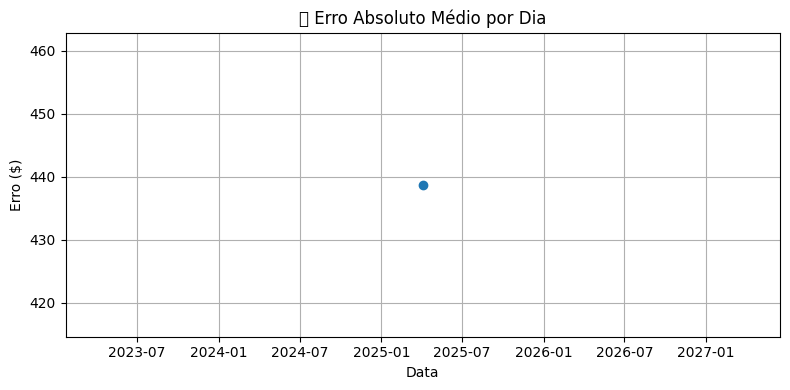

<ipython-input-44-b0f7868416c1>:669: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


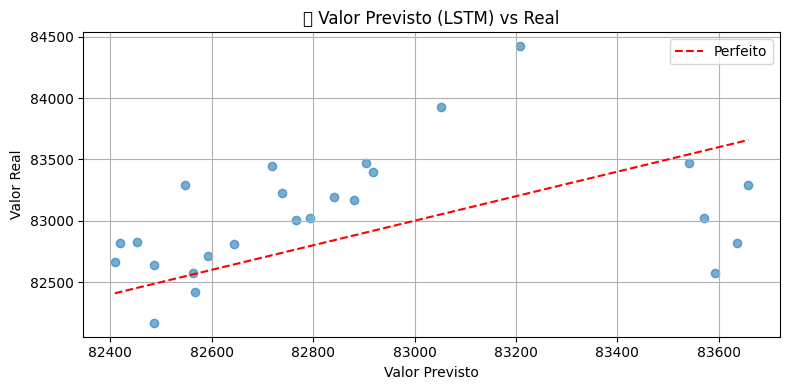

<ipython-input-44-b0f7868416c1>:679: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


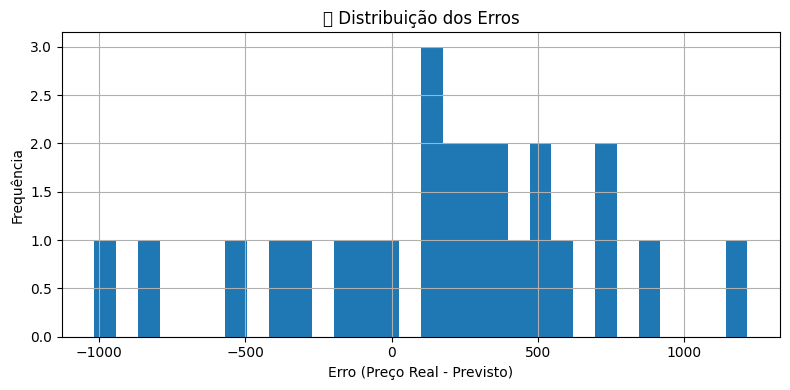

In [ ]:
plot_prediction_performance("/content/prediction_log.csv")


In [32]:
!rm /content/prediction_log.csv



📊 Total de previsões com valor previsto: 25


<ipython-input-44-b0f7868416c1>:656: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


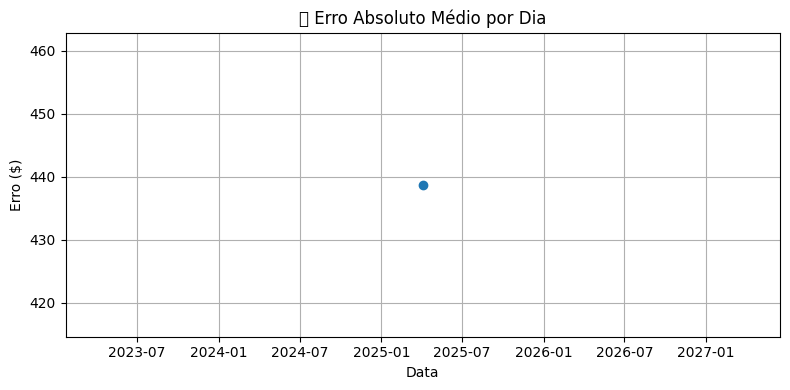

<ipython-input-44-b0f7868416c1>:669: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


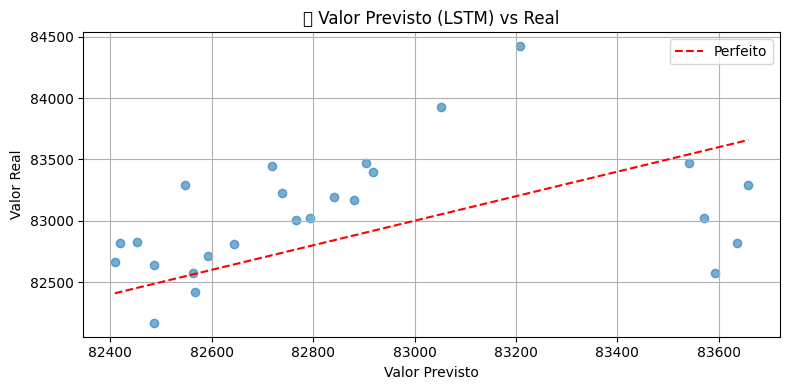

<ipython-input-44-b0f7868416c1>:679: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


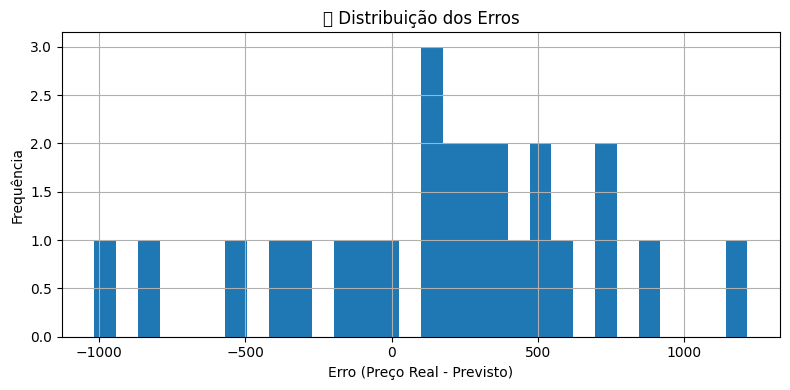

In [ ]:
plot_prediction_performance()

In [ ]:
import os
os.remove("trades_simulados.csv")
os.remove("prediction_log.csv")
print("🧹 Arquivos antigos apagados.")


🧹 Arquivos antigos apagados.


In [ ]:
run_analysis(
    selected_timeframes=[{"interval": "15m", "period": "30d", "atr": 0.02}],
    plot_timeframes=["15m"],
    alert_timeframes=["15m"]
)




📊 Analisando BTC-USD...
📂 Modelo LSTM encontrado em: /content/models/lstm_model_BTCUSD_15m.h5
❌ Falha ao carregar modelo LSTM: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
🚀 Treinando LSTM para BTC-USD (15m)...
🛠️ Features usadas para XGB_PRED: ['RSI', 'MACD', 'MACD_Signal', 'SMA_50', 'SMA_200', 'Bollinger_Upper', 'Bollinger_Lower', 'ADX', 'Stoch_K', 'Stoch_D', 'ATR', 'ROC', 'OBV', 'CCI', 'Tenkan_Sen', 'Kijun_Sen', 'VWAP', 'Doji', 'Engulfing', 'Hammer']


💾 Modelo LSTM salvo em: /content/models/lstm_model_BTCUSD_15m.h5
⚠️ Erro ao prever LSTM_PRED na linha 19: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 20: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 21: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 22: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 23: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 24: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 25: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 26: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 27: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 28: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM_PRED na linha 29: ❌ Coluna 'XGB_PRED' ausente no dataframe.
⚠️ Erro ao prever LSTM

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


📈 Walk-forward Results:
   fold  accuracy  precision    recall        f1   roc_auc  precision@10%
0     1    0.5625   0.548387  1.000000  0.708333  0.676471       0.909091
1     2    0.7500   1.000000  0.384615  0.555556  0.829960       1.000000
2     3    0.5000   0.000000  0.000000  0.000000  0.703125       1.000000
3     4    0.4375   0.000000  0.000000  0.000000  0.742063       0.750000
4     5    0.5625   0.400000  0.545455  0.461538  0.515152       0.250000

📊 Média final das métricas:
fold: 3.0000
accuracy: 0.5625
precision: 0.3897
recall: 0.3860
f1: 0.3451
roc_auc: 0.6934
precision@10%: 0.7818
💾 Modelo XGBoost salvo em: /content/models/xgb_model_BTCUSD_15m.joblib
📂 Modelo LSTM encontrado em: /content/models/lstm_model_BTCUSD_15m.h5
❌ Falha ao carregar modelo LSTM: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', '

In [ ]:
df_log.head()




In [ ]:
def salvar_grafico_evolucao():
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    if not os.path.exists("trades_simulados.csv"):
        print("❌ Arquivo de simulação não encontrado.")
        return

    try:
        df = pd.read_csv("trades_simulados.csv")
        if df.empty or "Data Entrada" not in df.columns:
            print("⚠️ Arquivo vazio ou colunas ausentes.")
            return

        df["Data Entrada"] = pd.to_datetime(df["Data Entrada"], errors="coerce")
        df = df[df["Data Entrada"].dt.year >= 2000]

        if df.empty:
            print("⚠️ Nenhum dado recente disponível para o gráfico.")
            return

        # Mapeamento de cores por tipo de trade
        color_map = {
            "TP1": "green",
            "SL": "red",
            "Sem alvo": "gray"
        }
        cores = df["Resultado"].map(color_map).fillna("blue")

        plt.figure(figsize=(10, 5))
        plt.plot(df["Data Entrada"], df["Capital Atual"], label="Capital", color="black", linewidth=2)
        plt.scatter(df["Data Entrada"], df["Capital Atual"], c=cores, label="Trades", zorder=5)
        plt.title("💰 Evolução da Carteira Virtual")
        plt.xlabel("Data")
        plt.ylabel("Capital ($)")
        plt.grid(True)
        plt.tight_layout()
        image_path = "/tmp/evolucao_carteira.png"
        plt.savefig(image_path)
        plt.close()
        print("✅ Gráfico salvo em:", image_path)

    except pd.errors.EmptyDataError:
        print("⚠️ trades_simulados.csv está vazio.")


In [ ]:
limpar_prediction_log()


In [ ]:
df = pd.read_csv("prediction_log.csv")
for i in range(5):
    print(f"Tipo de Signal linha {i}: {type(df.iloc[i]['Signal'])}, valor: {df.iloc[i]['Signal']}")


In [ ]:
def limpar_prediction_log(path="prediction_log.csv"):
    if not os.path.exists(path):
        print("⚠️ Arquivo de log não encontrado.")
        return

    df = pd.read_csv(path)
    df = df.dropna(subset=["Date"])
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].dt.year >= 2000]
    df.to_csv(path, index=False)
    print("✅ Log limpo com sucesso. Entradas de 1970 removidas!")

limpar_prediction_log()



⚠️ Arquivo de log não encontrado.


In [ ]:
import os
os.remove("/content/prediction_log.csv")

In [ ]:
def simular_todos_trades(path_log="prediction_log.csv"):
    if not os.path.exists(path_log):
        print("❌ Arquivo de log não encontrado.")
        return

    df_log = pd.read_csv(path_log)
    df_log["Date"] = pd.to_datetime(df_log["Date"], errors="coerce")
    df_log = df_log[df_log["Date"].dt.year >= 2000]
    df_log = df_log.dropna(subset=["Asset", "Timeframe", "Price", "TP1", "SL", "Signal"])

    # ✅ Ignora sinais neutros
    df_log = df_log[df_log["Signal"].isin([0, 1])]

    # 🔧 Garante que os valores sejam escalares
    df_log["Price"] = pd.to_numeric(df_log["Price"], errors="coerce")
    df_log["TP1"] = pd.to_numeric(df_log["TP1"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["SL"] = pd.to_numeric(df_log["SL"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["Signal"] = pd.to_numeric(df_log["Signal"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce", downcast="integer")

    sim_results = []

    for idx, row in df_log.iterrows():
        try:
            res = simular_trade(row)
            if res:
                sim_results.append(res)
        except Exception as e:
            print(f"❌ Erro ao simular linha {idx}: {e}")

    if not sim_results:
        print("⚠️ Nenhuma simulação válida foi executada.")
        return

    df_trades = pd.DataFrame(sim_results)
    df_trades["Capital Atual"] = pd.to_numeric(df_trades["Capital Atual"], errors="coerce")
    df_trades.to_csv("trades_simulados.csv", index=False)
    print("✅ Simulação concluída. Resultados salvos em trades_simulados.csv")

    # ✅ Diagnóstico final
    print(f"📊 Total de trades simulados: {len(df_trades)}")
    try:
        capital_final = df_trades["Capital Atual"].iloc[-1]
        if isinstance(capital_final, pd.Series):
            capital_final = capital_final.squeeze()
        capital_final = float(capital_final)
        print(f"💰 Capital final: ${capital_final:,.2f}")
    except Exception as e:
        print(f"⚠️ Erro ao exibir capital final: {e}")
        print(f"🧪 Valor bruto: {df_trades['Capital Atual'].iloc[-1]}")

    return df_trades


In [ ]:
import os
if os.path.exists("prediction_log.csv"):
    os.remove("prediction_log.csv")
    print("🧹 Carteira virtual resetada com sucesso.")


🧹 Carteira virtual resetada com sucesso.


In [ ]:
df = pd.read_csv("prediction_log.csv")
print(df.head(2).to_string())


     Asset Timeframe                        Date        Price  Signal  Confidence  AdjustedProb       TP1       TP2        SL  Accuracy  Precision  Recall  F1  LSTM_Predicted  TargetPrice
0  BTC-USD       15m  2025-04-04 11:19:23.609100  82147.09375       1         NaN           NaN  82968.56  83790.04  81325.62       NaN        NaN     NaN NaN        83130.04     83130.04
1  BTC-USD       15m  2025-04-04 11:19:55.182582  82147.09375       1         NaN           NaN  82968.56  83790.04  81325.62       NaN        NaN     NaN NaN        83130.04     83130.04


In [3]:
import yfinance as yf
import ta
import pandas as pd

# Teste simples para ver se tudo funciona:
df = yf.download("BTC-USD", period="5d", interval="15m")
print(df.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price                             Close          High           Low  \
Ticker                          BTC-USD       BTC-USD       BTC-USD   
Datetime                                                              
2025-04-01 00:00:00+00:00  82519.562500  82663.382812  82488.625000   
2025-04-01 00:15:00+00:00  82729.671875  82729.671875  82434.312500   
2025-04-01 00:30:00+00:00  82666.148438  82691.906250  82564.664062   
2025-04-01 00:45:00+00:00  82639.523438  82753.179688  82583.085938   
2025-04-01 01:00:00+00:00  82509.195312  82635.539062  82473.703125   

Price                              Open     Volume  
Ticker                          BTC-USD    BTC-USD  
Datetime                                            
2025-04-01 00:00:00+00:00  82488.625000  193460224  
2025-04-01 00:15:00+00:00  82482.765625  156729344  
2025-04-01 00:30:00+00:00  82658.570312   52002816  
2025-04-01 00:45:00+00:00  82702.617188          0  
2025-04-01 01:00:00+00:00  82635.539062          0  
